In [1]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

import matplotlib.pylab as pl
import matplotlib.image as mpimg
import matplotlib as mpl

from IPython.display import display, Image, clear_output
import ipywidgets as widgets

from timeit import default_timer as timer

import colorsys


## Load image

image width x height = 1024 x 768
nb pixel = 786432
nb colors = 238135
nb colors / nb pixels = 0.303


,R,G,B
pixel,,,
0,68,93,193
1,67,92,192
2,69,94,194


,R,G,B
pixel,,,
786429,219,208,206
786430,218,207,205
786431,216,205,203


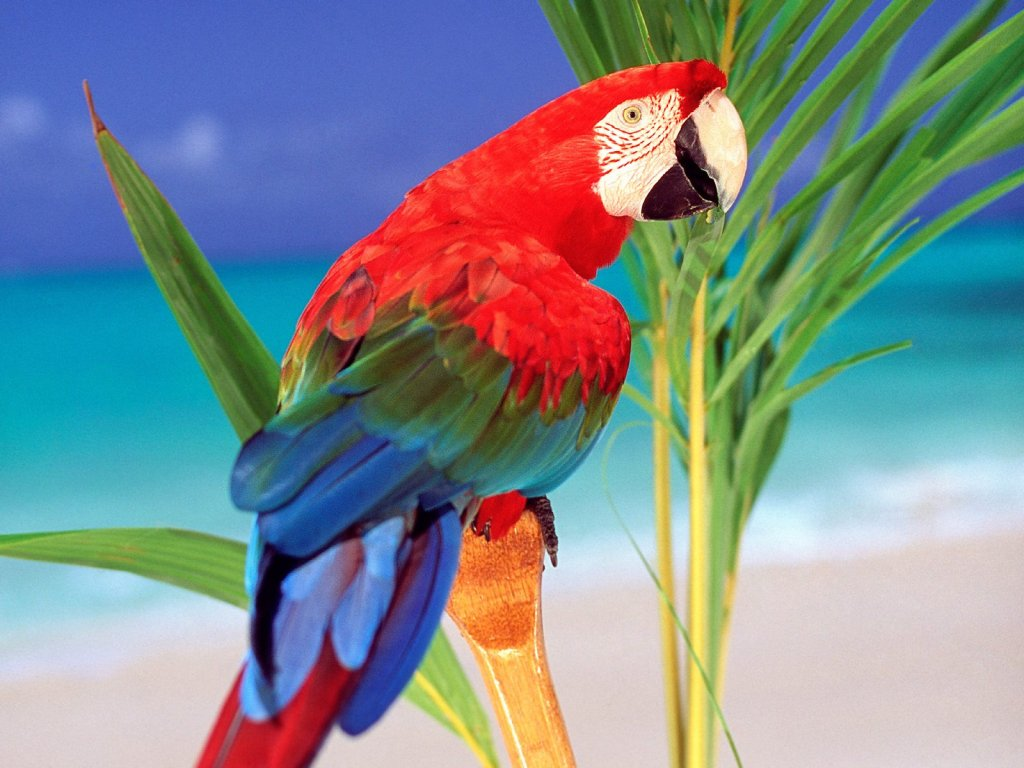

In [2]:
img = os.path.join('img', 'parrot.jpg')

im = mpimg.imread(img)
height, width, d = im.shape
im_lin = im.reshape(width*height, d)
im_lin_rescaled = im_lin / 255

df_img = pd.DataFrame(im_lin)
df_img.columns = ['R', 'G', 'B']
df_img.index.name = 'pixel'

nb_pixel = width * height
nb_color = len(df_img.drop_duplicates())

print('image width x height = {} x {}'.format(width, height))
print('nb pixel = {}'.format(width * height))
print('nb colors = {}'.format(nb_color))
print('nb colors / nb pixels = {:.3f}'.format(nb_color / nb_pixel))

display(df_img.head(3))
display(df_img.tail(3))
display(Image(img, width=width/1.5, height=height/1.5))


## Reduce number of colors using KMeans

+ Each RGB color is a 3-dimension vector where each dimension can have 256 values (from 0 to 255 included).  
+ The KMeans clustering algorithm is used on 10% of randomly selected pixels.  
+ Each original pixel is then mapped to the closest cluster center.  
+ The resulting image has a (much) smaller number of colors.  
+ The number of colors necessary for the human eye to be insensitive to any additional color granularity is what we want to discover here.  
+ Because integers are coded as bits, the interesting number of colors are the powers of two: 2, 4, 8, 16, 32, 64, 128, 256, etc.
+ But it is not immediate to go from color reduction to smaller file size as we will see.


In [3]:
def build_image(cluster_centers, labels, width, height):
    """Build image from KMeans ouput"""
    # Dimension of a center (3)
    d = cluster_centers.shape[1]
    # Init compressed image array
    arr_img = np.zeros((height, width, d))
    # Init index labels
    idx_label = 0
    # Reconstruction of the image, pixel by pixel
    for i in range(height):
        for j in range(width):
            arr_img[i][j] = cluster_centers[labels[idx_label]]
            idx_label += 1
    return arr_img


def sort_rgb(rgb, repetitions=1):
    """Sort colors in human eye convincing fashion"""
    r, g, b = rgb
    lum = np.sqrt( .241 * r + .691 * g + .068 * b )
    h, s, v = colorsys.rgb_to_hsv(r,g,b)
    h2 = int(h * repetitions)
    lum2 = int(lum * repetitions)
    v2 = int(v * repetitions)
    return (h2, lum, v2)


n_sample_learning = int(nb_pixel/100)
dic_img_comp = {}
t0 = timer()

for n_col in [2**i for i in range(1, 10)]:

    im_lin_rescaled_sample = np.random.permutation(im_lin_rescaled)[:n_sample_learning]
    kmeans = KMeans(n_clusters=n_col, random_state=0).fit(im_lin_rescaled_sample)
    labels = kmeans.predict(im_lin_rescaled)

    im_comp = build_image(kmeans.cluster_centers_, labels, width, height)

    colors = kmeans.cluster_centers_.tolist()
    colors = sorted(colors, key=lambda rgb: sort_rgb(rgb, 8))
    
    dic_img_comp[n_col] = {'im': im_comp, 'colors': colors}
    print('run time {:>6.2f} s\t\tNb colors = {}'.format(timer()-t0, n_col))
    

run time   1.62 s		Nb colors = 2
run time   3.32 s		Nb colors = 4
run time   5.07 s		Nb colors = 8
run time   7.06 s		Nb colors = 16
run time   9.57 s		Nb colors = 32
run time  12.89 s		Nb colors = 64
run time  17.66 s		Nb colors = 128
run time  25.56 s		Nb colors = 256
run time  39.43 s		Nb colors = 512


## Results

+ Arguably, the human eye (or at least mine) does not see more than 64 colors. Above that, the image quality does not seem to improve.  
+ Add some safety margin, this is probably why RGB colors are coded each on a byte = 8 bits = 2^8 = 256 distinct values.  


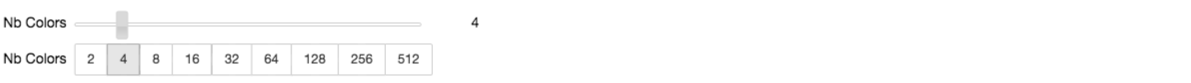

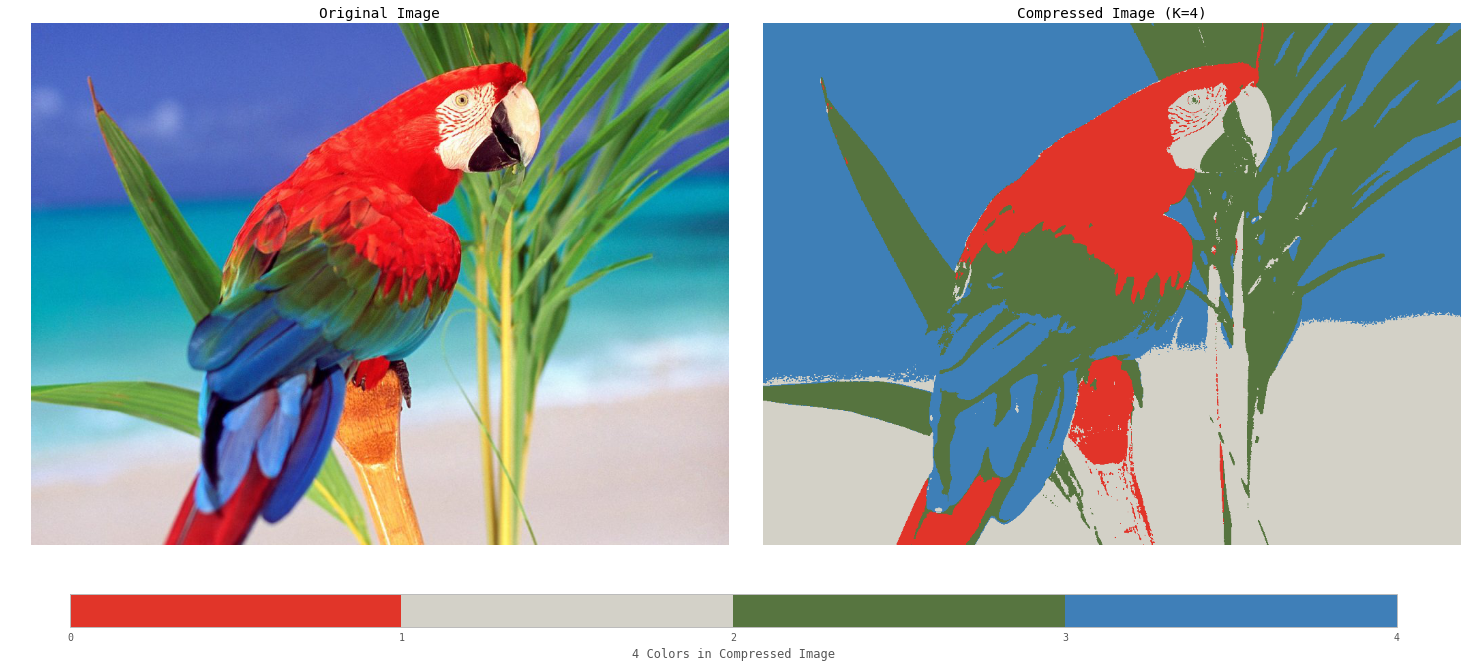

In [4]:
def show(n_col, dpi=100):
    
    im_comp = dic_img_comp[n_col]['im']
    colors = dic_img_comp[n_col]['colors']
    
    w_in, h_in = width/dpi, height/dpi
    fig, axes2d = pl.subplots(nrows=1, ncols=2, figsize=(w_in*2, h_in))
    axcb = fig.add_axes([0.05, -0.12, 0.9, 0.06])

    ax = axes2d[0]
    ax.axis('off')
    ax.set_title('Original Image')
    ax.imshow(im)

    ax2 = axes2d[1]
    ax2.axis('off')
    ax2.set_title('Compressed Image (K={})'.format(n_col))
    ax2.imshow(im_comp)

    cmap = mpl.colors.ListedColormap(colors)
    bounds = range(0, 1+len(colors))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, ticks=bounds, spacing='proportional', orientation='horizontal')
    cb.set_label('{} Colors in Compressed Image'.format(n_col))

    fig.tight_layout()
    
    return fig, ax2, axcb

    
def update(n_col, fig, ax2, axcb):
    
    im_comp = dic_img_comp[n_col]['im']
    colors = dic_img_comp[n_col]['colors']
    
    ax2.imshow(im_comp)
    ax2.set_title('Compressed Image (K={})'.format(n_col))
    
    cmap = mpl.colors.ListedColormap(colors)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, spacing='proportional', orientation='horizontal')
    cb.set_label('{} Colors in Compressed Image'.format(n_col))
    clear_output(wait=True)
    display(fig)
    
    
n_col = 4
rng = sorted(dic_img_comp.keys())

fig, ax2, axcb = show(n_col)
slider = widgets.SelectionSlider(value=n_col, options=rng, width='520px', description='Nb Colors')
buttons = widgets.ToggleButtons(value=n_col, options=rng, width='500px', description='Nb Colors')


def on_slider_change(change):
    n_col = change['new']
    update(n_col, fig, ax2, axcb)

slider.observe(on_slider_change, names='value')
buttons.observe(on_slider_change, names='value')
widgets.jslink((slider, 'value'), (buttons, 'value'))

display(slider)
display(buttons)


In [5]:
dpi = 150
w_in, h_in = width/dpi, height/dpi

img_uncomp = os.path.join('img', 'parrot_orig.jpg')
fig = pl.figure(figsize=(w_in, h_in))
pl.axis('off')
pl.imshow(dic_img_comp[64]['im'])
pl.savefig(img_uncomp, dpi=dpi)
pl.clf()

img_comp64 = os.path.join('img', 'parrot_comp_64.jpg')
fig = pl.figure(figsize=(w_in, h_in))
pl.axis('off')
pl.imshow(dic_img_comp[64]['im'])
pl.savefig(img_comp64, dpi=dpi)
pl.clf()


## From color reduction to image compression

+ So for a large image, the amout of data is reduced by a factor $3*8/6=4$ as each color point initially coded on 3*8 bits (which allows $256^3=16777216$ distinct values) is now store on 6 bits ($2^6=64$ distinct values), neglecting the size to store the cluster centers, but there are very few compared to the number of pixels.
+ But this simple sum does not directly translate into actual file sizes as the image format compression algorithms a lot of complex operations to remove any info that the human eye cannot perceive from the image data.  

+  For exemple on this image the number of bits to store the compressed image is MUCH bigger than the actual file size, which shows that the JPG format is a lot more efficient than simply the color clustering algo described here.
+ Even worse, the compressed image is the same size as the uncompressed image on disk, and the uncompressed image after this processing is bigger that the oringal image (!)
+ Obvious, but worse stating anyway.


+ Note: Comparing the original image with the ones produced by matplotlib is not straight forward as there is this white border I dont' know how to get rid of...

In [6]:
nb_pixel = width * height
nb_byte_per_point = 1 # 8 bits
nb_kbyte = nb_pixel * nb_byte_per_point
size_orig = os.stat(img).st_size
size_uncomp = os.stat(img_uncomp).st_size
size_comp64 = os.stat(img_comp64).st_size

print('Compressed image size naive expected size = {:,}'.format(nb_kbyte))
print('\nOriginal jpg image on disk = {:,}'.format(size_orig/1000))
print('\nUnCompressed jpg image on disk = {:,}'.format(size_uncomp/1000))
print('Compressed to 64 colors jpg image on disk = {:,}'.format(size_comp64/1000))


Compressed image size naive expected size = 786,432

Original jpg image on disk = 122.144

UnCompressed jpg image on disk = 162.155
Compressed to 64 colors jpg image on disk = 162.155
